# Система классификации изображений драгоценных камней на основе сверточных нейронных сетей

## Теоретическая база

Сверточные нейронные сети являются основным инструментом для задач компьютерного зрения. В отличие от полносвязных сетей, CNN используют операцию свертки для эффективного извлечения пространственных признаков из изображений.

Основные компоненты:
* Сверточные слои - извлекают признаки и увеличивают количество измерений.
* Пулинговые слои - уменьшают пространственную размерность
* Функции активации (ReLU) - добавляют нелинейность
* Полносвязные слои - выполняют классификацию на основе извлеченных признаков

В работе используются предобученные на ImageNet модели.  

* ResNet50 - архитектура с остаточными связями
* ResNet18 - легковесная версия ResNet
* EfficientNet-B3 - современная архитектура, оптимизирующая глубину, ширину и разрешение

Для оценки моделей использовались следующие метрики:
* F1-score (weighted) - взвешенное по размеру классов среднее
* Confusion Matrix - матрица ошибок для анализа проблемных классов

## Описание разработанной системы

### Зависимости

In [ ]:
%pip install kagglehub
%pip install torch
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install pandas
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 9.6 MB/s  0:00:016m0:00:0100:01
Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (35.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import copy
import shutil
from collections import defaultdict
import random
import pandas as pd
from tabulate import tabulate

/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Датасет

Использован датасет "Gemstones Images" с Kaggle (lsind18/gemstones-images). Датасет содержит изображения 87 видов различных драгоценных камней. Всего в датасете около 3000. Для обучения датасет поделен на train, test, split (60/20/20).

#### Скачивание и распаковка датасета

In [27]:
path = kagglehub.dataset_download("lsind18/gemstones-images")

In [28]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [29]:
target_dir = base_dir

In [30]:
def collect_all_images(dataset_path):
    """
    Собирает все изображения из папок train и test оригинального датасета
    Возвращает словарь: {класс: [список путей к изображениям]}
    """
    all_images = defaultdict(list)
    
    # Проходим по папкам train и test
    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"Папка {split_path} не найдена")
            continue
            
        # Проходим по классам в каждой папке
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
                
            # Собираем все изображения в этом классе
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    img_path = os.path.join(class_path, img_file)
                    all_images[class_name].append(img_path)
    
    return all_images

# Собираем все изображения
all_images = collect_all_images(path)


In [31]:
def split_and_save_dataset(all_images, target_base_dir, train_ratio=0.6, val_ratio=0.2, seed=42):
    random.seed(seed)
    
    for class_name, image_paths in sorted(all_images.items()):
        # Перемешиваем изображения
        random.shuffle(image_paths)
        
        # Вычисляем размеры выборок
        total = len(image_paths)
        n_train = int(total * train_ratio)
        n_val = int(total * val_ratio)
        
        # Разделяем на три части
        train_paths = image_paths[:n_train]
        val_paths = image_paths[n_train:n_train + n_val]
        test_paths = image_paths[n_train + n_val:]
        
        # Создаем папки для класса
        for split in ['train', 'val', 'test']:
            class_dir = os.path.join(target_base_dir, split, class_name)
            os.makedirs(class_dir, exist_ok=True)
        
        # Копируем файлы
        # Train
        for src_path in train_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'train', class_name, filename)
            shutil.copy2(src_path, dst_path)
        
        # Validation
        for src_path in val_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'val', class_name, filename)
            shutil.copy2(src_path, dst_path)
        
        # Test
        for src_path in test_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'test', class_name, filename)
            shutil.copy2(src_path, dst_path)
            
# Запускаем разделение
split_stats = split_and_save_dataset(all_images, target_dir, train_ratio=0.6, val_ratio=0.2)

Датасет скачан и перераспределен на 3 части вместо 2х как было изначально.

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cpu


In [33]:
NUM_EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.01

#### Загрузка датасета в код

В следующем отрезке кода, пытаемся сделать учебные фотографии максимально разными поворачивать их, зеркалить изменять яркость и контрастность, но это снизило эффективность обучения. И приводим все остальные фотографии к формату 224х224

In [ ]:
data_dir = target_dir

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [35]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

#### Размеры датасета 
В выводе следующей ячейки приведены размеры датасета

In [36]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Классы: {class_names}")
print(f"Размеры датасета: Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

Классы: ['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Danburite', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 'Serpentine', 'Sodalite', 'Spe

### Модель

#### Скачиваем и изменяем модель
Заменяем последний слой на 87 классов

In [37]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))
#model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
#model_ft.classifier[1] = nn.Linear(model_ft.classifier[1].in_features, len(class_names))

Название изменяемых слове зависит от модели, поэтому менял в ручную, хотя можно было бы наверное просто объединить.

In [38]:
for name, param in model_ft.named_parameters():
    if "fc.weight" not in name and "fc.bias" not in name:#if "classifier.1.weight" not in name and "classifier.1.bias" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [39]:
model_ft = model_ft.to(device)
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)

In [40]:
print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")


Всего параметров: 23,686,295
Обучаемых параметров: 178,263 (0.8%)


Наша задача обучить в первую очередь классификатор, потому что модель и так определяет все особенности картинки так как она заточена под ImageNet.

#### 

In [41]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE, momentum=0.9)
#optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE, weight_decay=0.01 )

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=NUM_EPOCHS)

In [42]:
from tqdm import tqdm
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Внешний прогресс-бар для эпох
    epoch_pbar = tqdm(range(num_epochs), desc='Epochs', position=0)
    
    for epoch in epoch_pbar:
        # Обновляем описание для эпохи
        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs-1}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                # Прогресс-бар для тренировки
                pbar = tqdm(dataloaders[phase], desc=f'Training', 
                           leave=False, position=1)
            else:
                model.eval()
                # Прогресс-бар для валидации
                pbar = tqdm(dataloaders[phase], desc=f'Validation', 
                           leave=False, position=1)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Обновляем прогресс-бар с текущими метриками
                if phase == 'train':
                    pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{torch.sum(preds == labels.data).item()/len(labels):.4f}'
                    })
                else:
                    pbar.set_postfix({
                        'val_acc': f'{torch.sum(preds == labels.data).item()/len(labels):.4f}'
                    })

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Обновляем описание основного прогресс-бара
            if phase == 'train':
                epoch_pbar.set_postfix({
                    'train_loss': f'{epoch_loss:.4f}',
                    'train_acc': f'{epoch_acc:.4f}'
                })
            else:
                epoch_pbar.set_postfix({
                    'train_loss': f'{history["train_loss"][-1]:.4f}' if history['train_loss'] else 0,
                    'train_acc': f'{history["train_acc"][-1]:.4f}' if history['train_acc'] else 0,
                    'val_loss': f'{epoch_loss:.4f}',
                    'val_acc': f'{epoch_acc:.4f}'
                })

            # Сохраняем лучшую модель
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Показываем сообщение о новом лучшем результате

    time_elapsed = time.time() - since
    print(f'\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f' Best val Acc: {best_acc:.4f}')

    # Загружаем лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, history

In [19]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=NUM_EPOCHS)

Epoch 14/14: 100%|██████████| 15/15 [42:49<00:00, 171.31s/it, train_loss=0.6231, train_acc=0.8648, val_loss=1.0255, val_acc=0.7010]


 Training complete in 42m 50s
 Best val Acc: 0.7059


In [20]:
model_path = 'best_model_resNet50_NotShifted.pth'
torch.save(model_ft.state_dict(), model_path)

In [21]:
models_dict = {}

# Проходим по всем файлам в директории
for filename in os.listdir():
    if filename.endswith(".pth"):
        print(f"\n Загрузка модели: {filename}")
        
        # Создаем новую модель с той же архитектурой
        if "18" in filename:
            model = models.resnet18(weights=None)  # Создаем пустую модель
        elif "efficientnet_b3" in filename:
            model=models.efficientnet_b3(weights=None)
        else:
            model=models.resnet50(weights=None)
        if "efficientnet_b3" in filename:
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
        else:
            model.fc = nn.Linear(model.fc.in_features, len(class_names))
        # Загружаем сохраненные веса
        if filename == "best_model_resnet18.pth":
            # Если это просто сохраненный state_dict
            state_dict = torch.load(filename, map_location=device)
            model.load_state_dict(state_dict)
        else:
            # Если это полный чекпоинт с словарем
            checkpoint = torch.load(filename, map_location=device)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            else:
                model.load_state_dict(checkpoint)
        
        # Переносим модель на устройство
        model = model.to(device)
        model.eval()  # Переводим в режим оценки
        
        models_dict[filename] = model
        print(f" Модель загружена и готова к оценке")

print(f"\nЗагружено моделей: {len(models_dict)}")


 Загрузка модели: best_model_resNet50_NotShifted.pth
 Модель загружена и готова к оценке

 Загрузка модели: best_model_resNet18_withShift.pth
 Модель загружена и готова к оценке

 Загрузка модели: best_model_resnet18.pth
 Модель загружена и готова к оценке

 Загрузка модели: best_model_resNet50.pth
 Модель загружена и готова к оценке

 Загрузка модели: best_model_efficientnet_b3.pth
 Модель загружена и готова к оценке

Загружено моделей: 5


In [22]:
def evaluate_model_with_f1(model, dataloader, class_names, dataset_size):
    """
    Оценка модели с использованием F1-score и матрицы ошибок
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Оценка модели на тестовой выборке...")
    print("-" * 50)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Преобразуем в numpy массивы
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # 1. Считаем accuracy (для сравнения)
    accuracy = np.mean(all_preds == all_labels)
    
    # 2. Считаем macro F1-score (среднее по классам)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    # 3. Считаем weighted F1-score (взвешенное по поддержке классов)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    # 4. Считаем per-class F1-score
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (weighted): {f1_weighted:.4f}")
    print()
    
    # 5. Детальный отчет по классам
    print("Детальный отчет по классам:")
    print("-" * 70)
    print(f"{'Класс':<25} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
    print("-" * 70)
    
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = report[class_name]['support']
        print(f"{class_name:<25} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f} {support:<10.0f}")
    
    print("-" * 70)
    print(f"{'Среднее (macro)':<25} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} {report['macro avg']['f1-score']:<10.4f} {dataset_size:<10.0f}")
    
    return all_preds, all_labels, all_probs, {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'report': report
    }

In [23]:
def plot_confusion_matrix(all_labels, all_preds, class_names):
    """
    Матрица ошибок: тепловая карта + текстовый анализ
    Для 87 классов - подписи классов убираем, оставляем только визуализацию
    """
    # Вычисляем матрицу ошибок
    cm = confusion_matrix(all_labels, all_preds)
    
    # Создаем фигуру
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Абсолютные значения (тепловая карта без подписей)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=False, yticklabels=False,  # Убираем подписи
                ax=axes[0], cbar_kws={'label': 'Количество изображений'})
    axes[0].set_title('Матрица ошибок (абсолютные значения)\n87 классов', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Истинный класс', fontsize=12)
    axes[0].set_xlabel('Предсказанный класс', fontsize=12)
    
    # 2. Нормализованные значения (тепловая карта без подписей)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='YlOrRd', 
                xticklabels=False, yticklabels=False,  # Убираем подписи
                ax=axes[1], cbar_kws={'label': 'Доля от класса'}, 
                vmin=0, vmax=1)
    axes[1].set_title('Матрица ошибок (нормализованная по строкам)\n87 классов', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Истинный класс', fontsize=12)
    axes[1].set_xlabel('Предсказанный класс', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ самых частых ошибок (текстовый вывод)
    print("\n Анализ самых частых ошибок:")
    print("=" * 60)
    
    # Общая статистика
    total_samples = len(all_labels)
    correct = np.trace(cm)
    accuracy = correct / total_samples
    
    print(f" Всего изображений: {total_samples}")
    print(f" Правильно: {correct} ({accuracy:.2%})")
    print(f" Ошибок: {total_samples - correct} ({1-accuracy:.2%})")
    print("-" * 60)
    
    # Находим топ ошибок (убираем диагональ)
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0)
    
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm_errors[i, j] > 0:
                errors.append((cm_errors[i, j], i, j))
    
    errors.sort(reverse=True)
    
    # Топ-10 ошибок с названиями классов
    print("\n Топ-10 самых частых ошибок:")
    for idx, (count, true_idx, pred_idx) in enumerate(errors[:10], 1):
        error_percent = count / cm[true_idx].sum() * 100
        print(f"{idx:2d}. {class_names[true_idx]:35} → {class_names[pred_idx]:35} : {count:4d} ({error_percent:.1f}%)")
    
    return cm, cm_normalized



best_model_resNet50_NotShifted.pth

Оценка модели на тестовой выборке...
--------------------------------------------------
Accuracy: 0.6983
F1-score (macro): 0.6898
F1-score (weighted): 0.6978

Детальный отчет по классам:
----------------------------------------------------------------------
Класс                     Precision  Recall     F1-score   Support   
----------------------------------------------------------------------
Alexandrite               0.8333     0.5556     0.6667     9         
Almandine                 0.2000     0.1429     0.1667     7         
Amazonite                 1.0000     0.8750     0.9333     8         
Amber                     0.7500     0.4286     0.5455     7         
Amethyst                  0.3333     0.5556     0.4167     9         
Ametrine                  0.6000     1.0000     0.7500     9         
Andalusite                0.7143     0.6250     0.6667     8         
Andradite                 0.2727     0.4286     0.3333     7         
Aqu

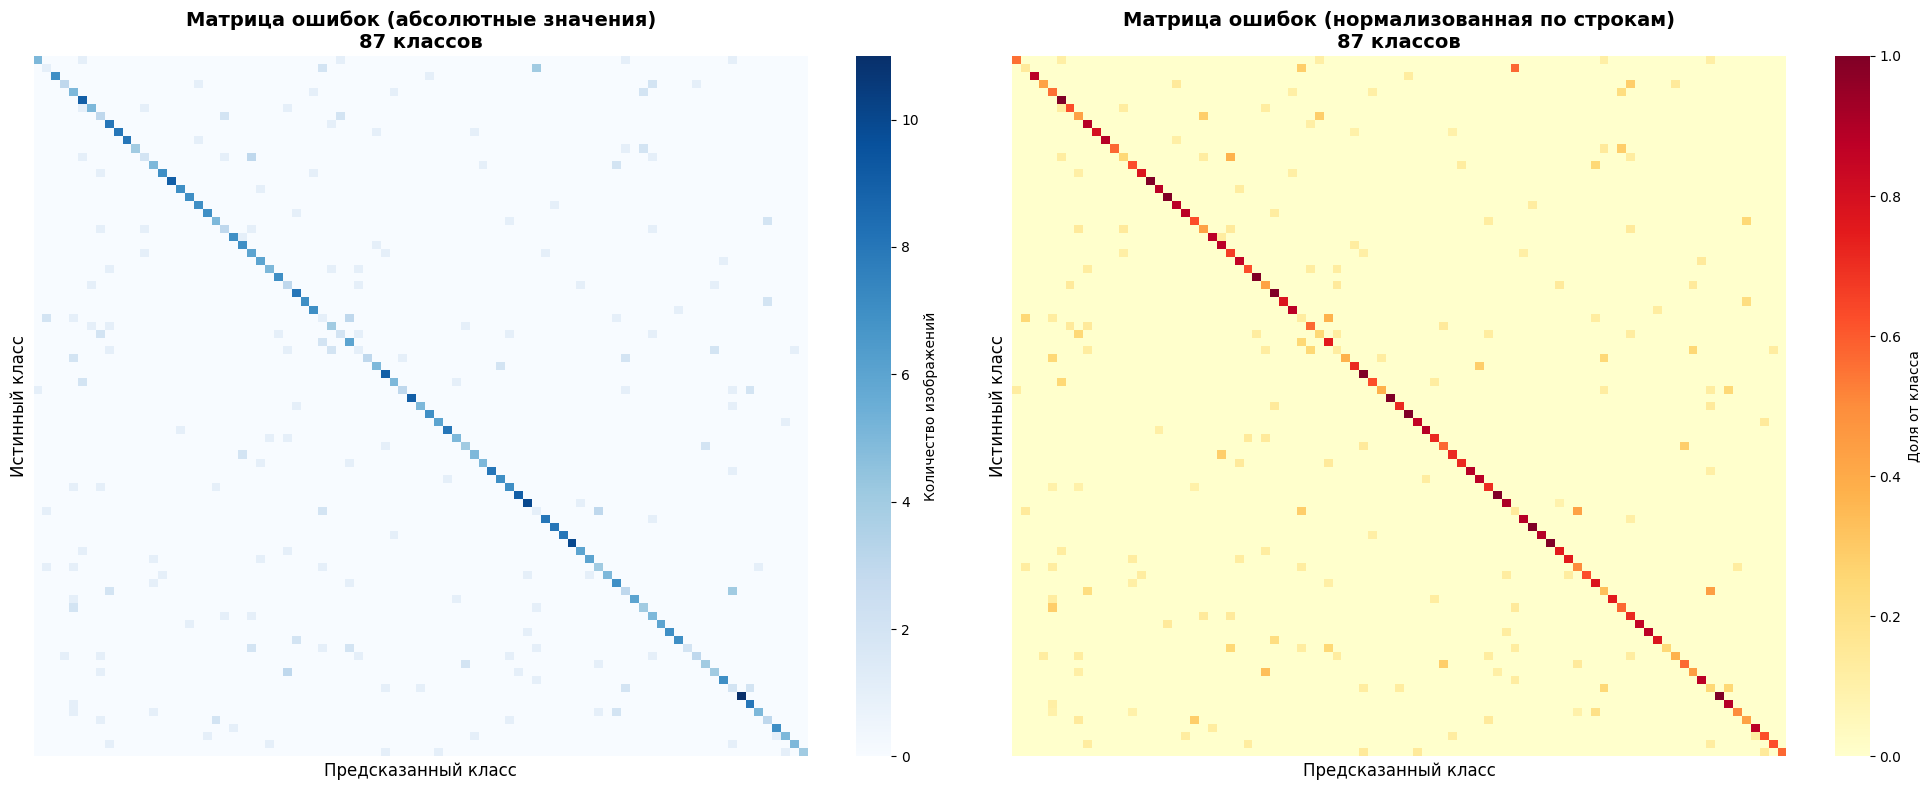


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 493 (69.83%)
 Ошибок: 213 (30.17%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Sapphire Blue                       → Tanzanite                           :    4 (44.4%)
 2. Almandine                           → Pyrope                              :    4 (57.1%)
 3. Spodumene                           → Diaspore                            :    3 (33.3%)
 4. Pyrope                              → Rhodolite                           :    3 (42.9%)
 5. Garnet Red                          → Hessonite                           :    3 (37.5%)
 6. Beryl Golden                        → Citrine                             :    3 (37.5%)
 7. Tsavorite                           → Chrome Diopside                     :    2 (28.6%)
 8. Tourmaline                          → Ruby                                :    2 (20.0%)
 9. Tanzanite                           → Topaz                 

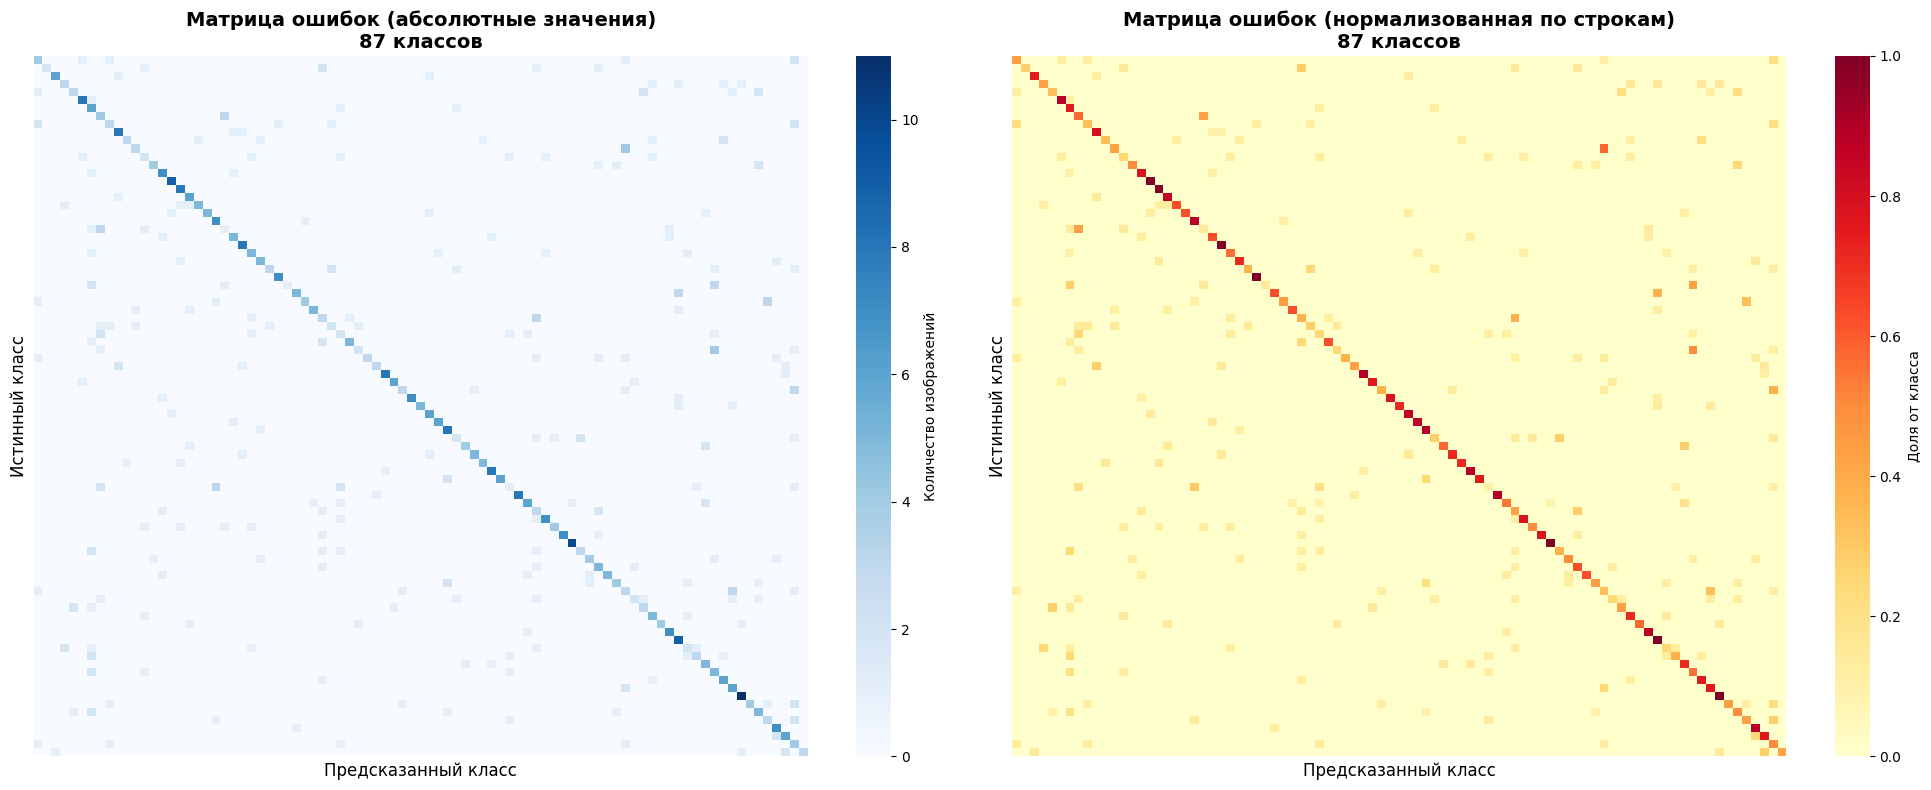


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 424 (60.06%)
 Ошибок: 282 (39.94%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Hiddenite                           → Spodumene                           :    4 (50.0%)
 2. Benitoite                           → Sapphire Blue                       :    4 (57.1%)
 3. Sapphire Blue                       → Tanzanite                           :    3 (33.3%)
 4. Peridot                             → Chrome Diopside                     :    3 (30.0%)
 5. Kyanite                             → Zircon                              :    3 (37.5%)
 6. Garnet Red                          → Pyrope                              :    3 (37.5%)
 7. Emerald                             → Tsavorite                           :    3 (33.3%)
 8. Dumortierite                        → Sodalite                            :    3 (37.5%)
 9. Diaspore                            → Spodumene             

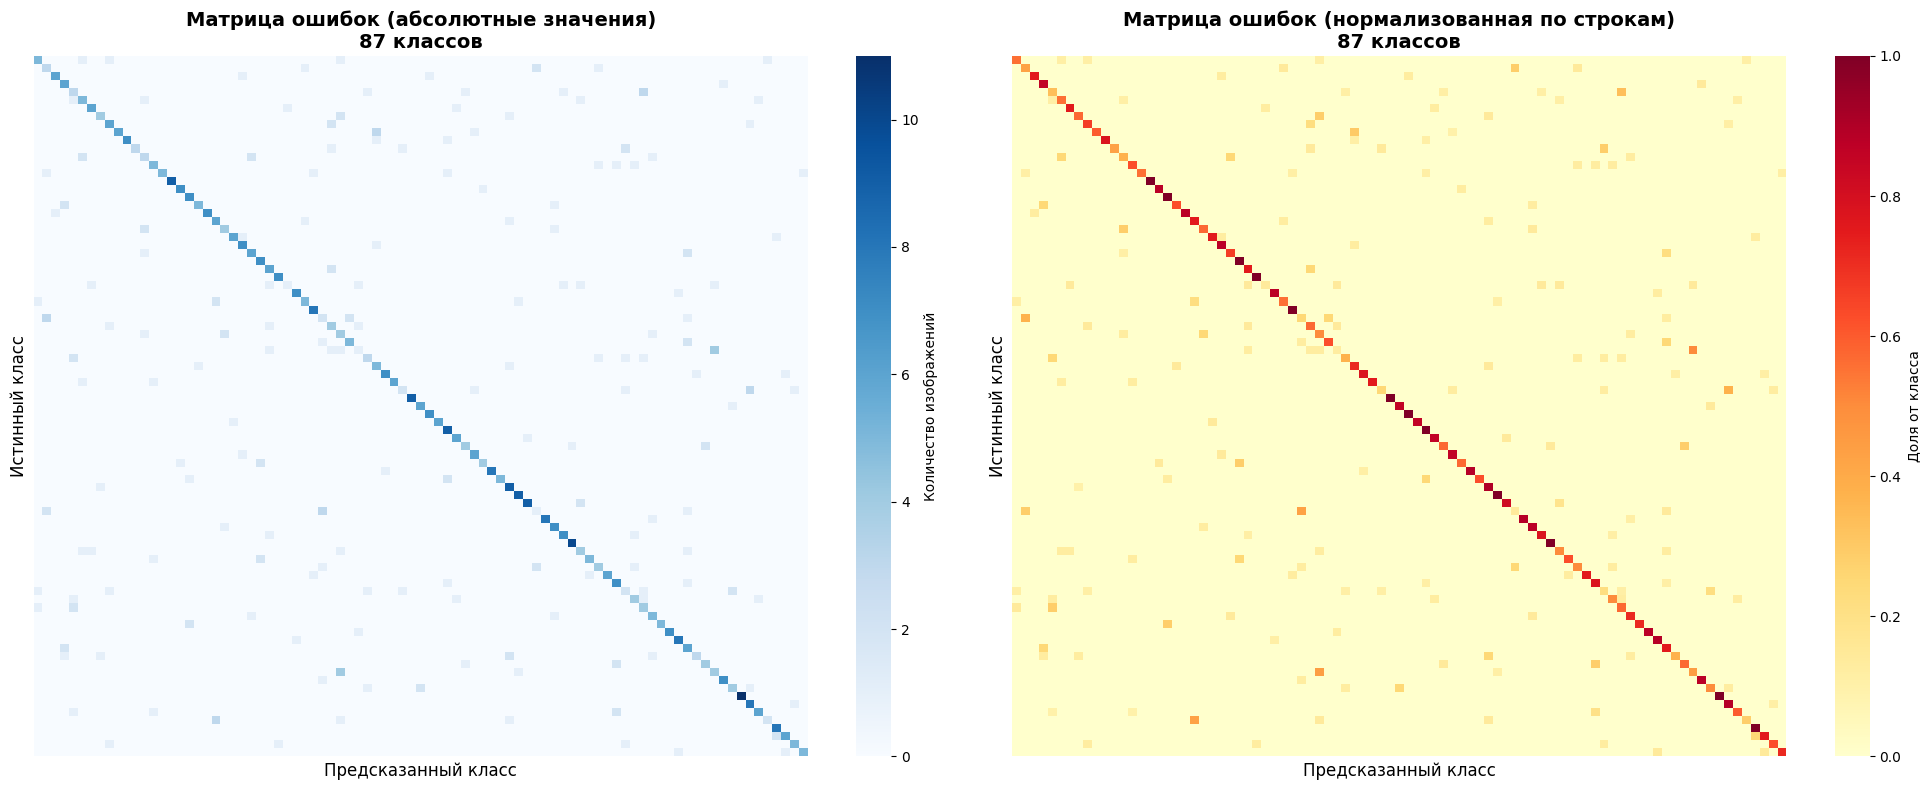


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 487 (68.98%)
 Ошибок: 219 (31.02%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Spodumene                           → Grossular                           :    4 (44.4%)
 2. Hiddenite                           → Spodumene                           :    4 (50.0%)
 3. Tsavorite                           → Chrome Diopside                     :    3 (42.9%)
 4. Pyrope                              → Garnet Red                          :    3 (42.9%)
 5. Kyanite                             → Topaz                               :    3 (37.5%)
 6. Garnet Red                          → Almandine                           :    3 (37.5%)
 7. Aventurine Green                    → Jade                                :    3 (30.0%)
 8. Amethyst                            → Sapphire Purple                     :    3 (33.3%)
 9. Variscite                           → Turquoise             

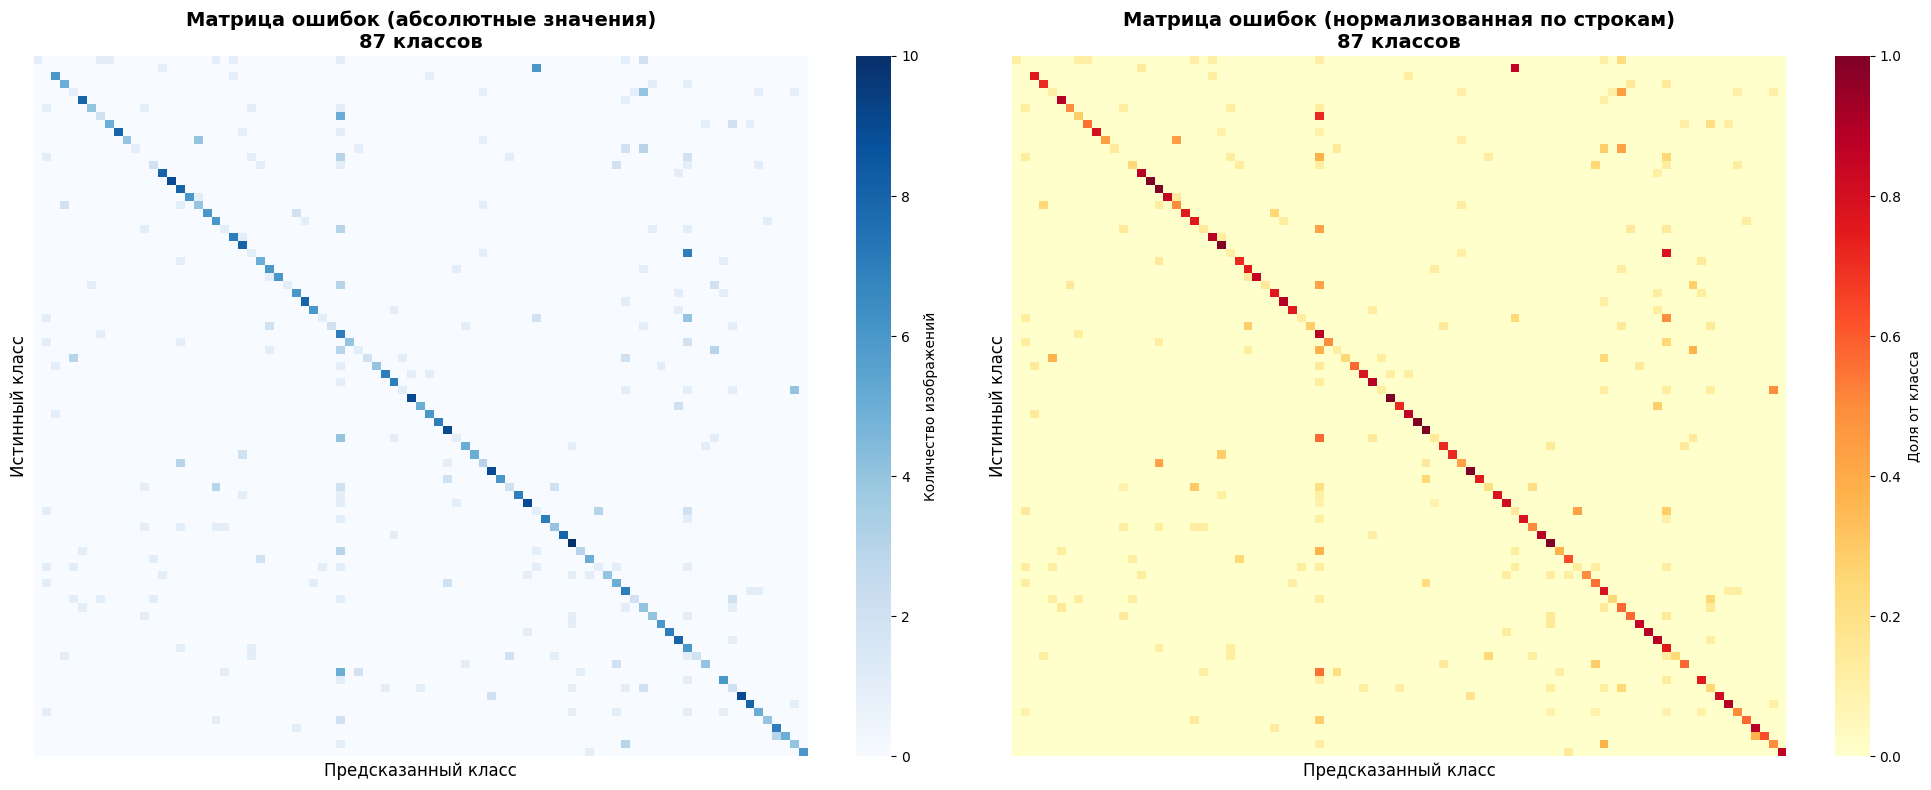


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 422 (59.77%)
 Ошибок: 284 (40.23%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Citrine                             → Spessartite                         :    7 (77.8%)
 2. Almandine                           → Pyrope                              :    6 (85.7%)
 3. Spodumene                           → Grossular                           :    5 (55.6%)
 4. Andradite                           → Grossular                           :    5 (71.4%)
 5. Morganite                           → Grossular                           :    4 (57.1%)
 6. Kyanite                             → Zircon                              :    4 (50.0%)
 7. Garnet Red                          → Spessartite                         :    4 (50.0%)
 8. Aventurine Yellow                   → Chalcedony                          :    4 (44.4%)
 9. Amethyst                            → Sapphire Purple       

/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

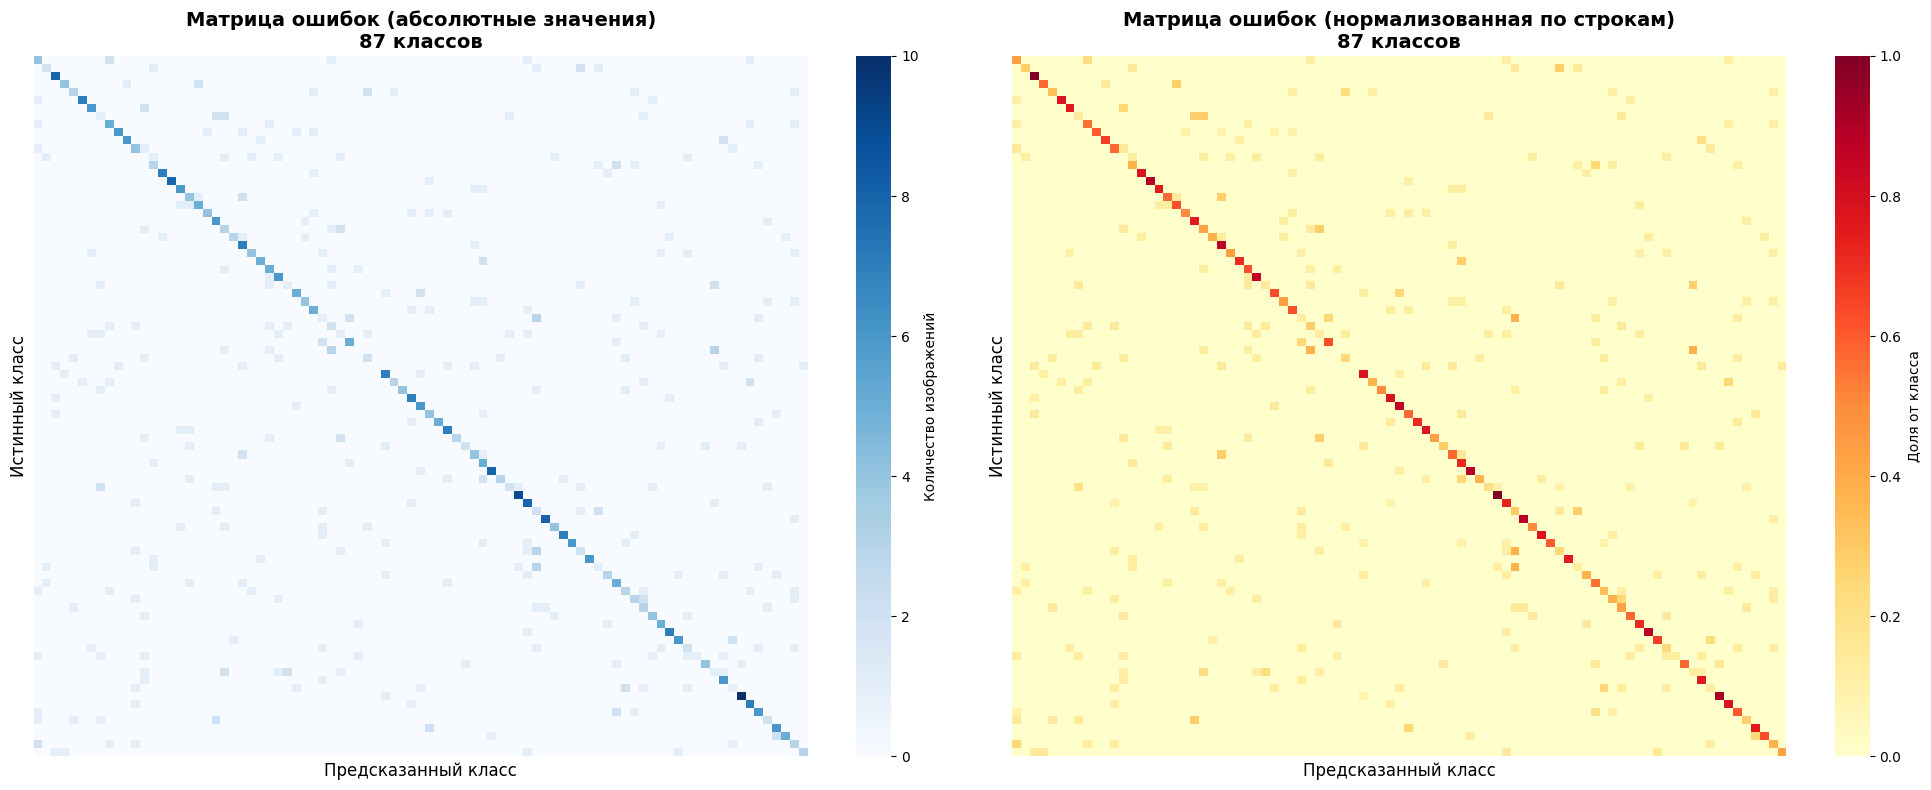


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 377 (53.40%)
 Ошибок: 329 (46.60%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Rhodolite                           → Pyrope                              :    3 (37.5%)
 2. Quartz Smoky                        → Pyrope                              :    3 (37.5%)
 3. Hiddenite                           → Spodumene                           :    3 (37.5%)
 4. Hiddenite                           → Goshenite                           :    3 (37.5%)
 5. Garnet Red                          → Pyrope                              :    3 (37.5%)
 6. Zircon                              → Alexandrite                         :    2 (25.0%)
 7. Variscite                           → Turquoise                           :    2 (25.0%)
 8. Turquoise                           → Larimar                             :    2 (25.0%)
 9. Tsavorite                           → Chrome Diopside       

In [24]:
for name, value in models_dict.items():
    print("\n\n"+name+"\n")
    preds, labels, probs, metrics = evaluate_model_with_f1(
        value, dataloaders['test'], class_names, dataset_sizes['test']
    )
    # Используем функцию
    cm, cm_norm = plot_confusion_matrix(labels, preds, class_names)

In [25]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.



📥 Загрузка модели: best_model_resNet50_NotShifted.pth
  ✅ Модель загружена

📥 Загрузка модели: best_model_resNet18_withShift.pth
  ✅ Модель загружена

📥 Загрузка модели: best_model_resnet18.pth
  ✅ Модель загружена

📥 Загрузка модели: best_model_resNet50.pth
  ✅ Модель загружена

📥 Загрузка модели: best_model_efficientnet_b3.pth
  ✅ Модель загружена

📊 Оценка модели: best_model_resNet50_NotShifted.pth
Оценка модели на тестовой выборке...
--------------------------------------------------
Accuracy: 0.6983
F1-score (macro): 0.6898
F1-score (weighted): 0.6978

Детальный отчет по классам:
----------------------------------------------------------------------
Класс                     Precision  Recall     F1-score   Support   
----------------------------------------------------------------------
Alexandrite               0.8333     0.5556     0.6667     9         
Almandine                 0.2000     0.1429     0.1667     7         
Amazonite                 1.0000     0.8750     0.9333 

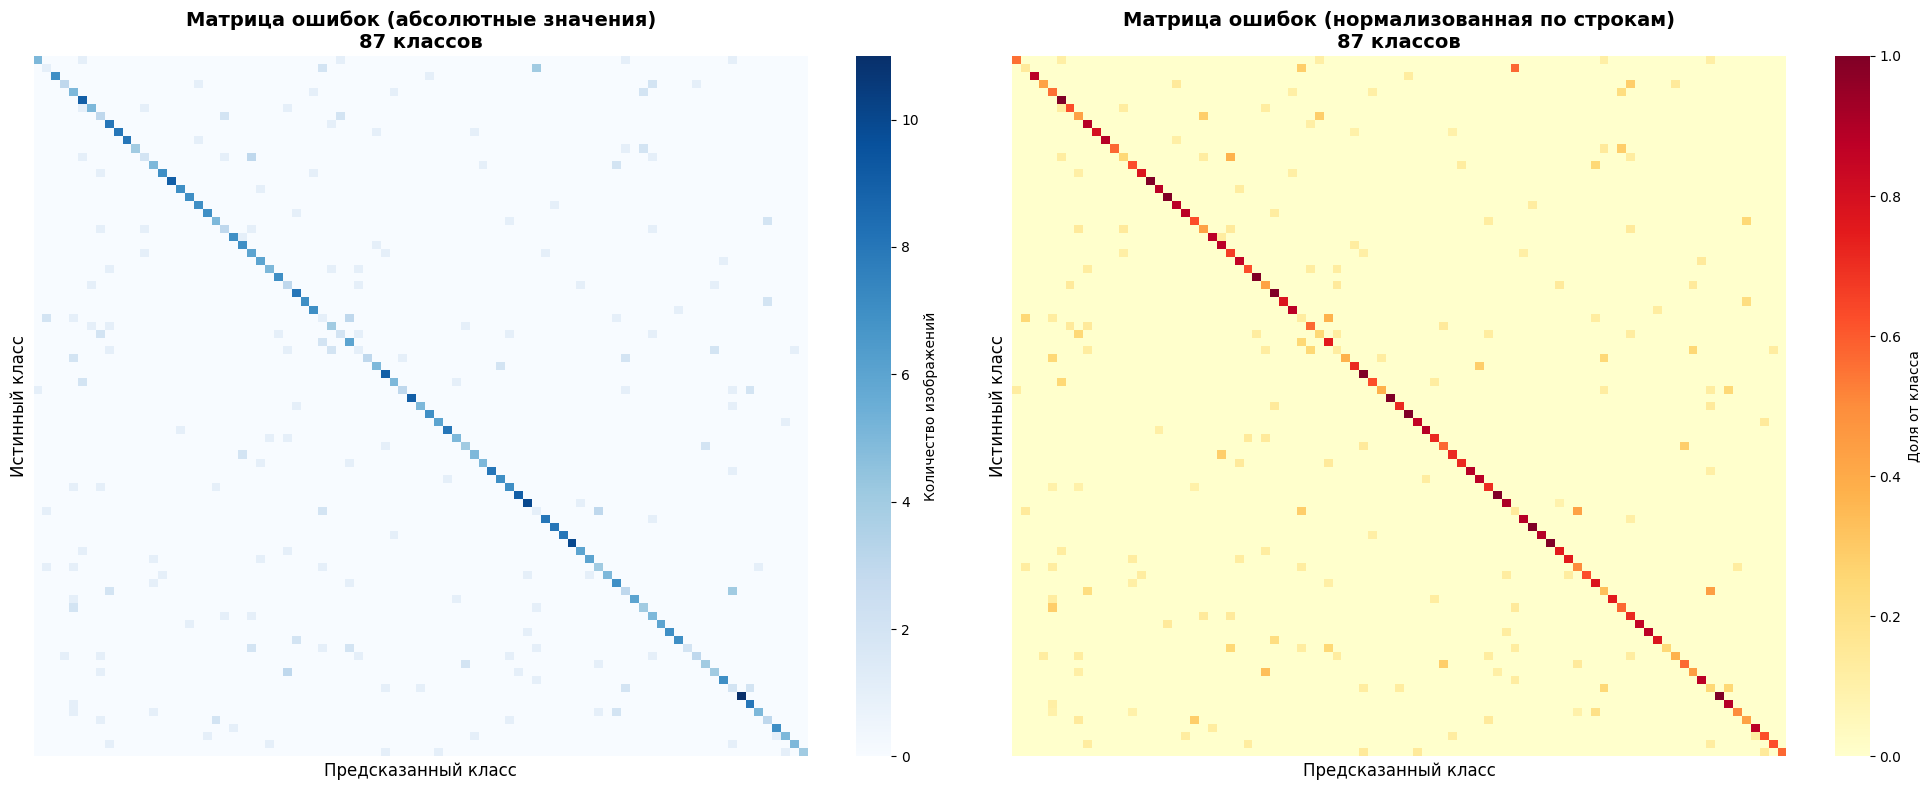


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 493 (69.83%)
 Ошибок: 213 (30.17%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Sapphire Blue                       → Tanzanite                           :    4 (44.4%)
 2. Almandine                           → Pyrope                              :    4 (57.1%)
 3. Spodumene                           → Diaspore                            :    3 (33.3%)
 4. Pyrope                              → Rhodolite                           :    3 (42.9%)
 5. Garnet Red                          → Hessonite                           :    3 (37.5%)
 6. Beryl Golden                        → Citrine                             :    3 (37.5%)
 7. Tsavorite                           → Chrome Diopside                     :    2 (28.6%)
 8. Tourmaline                          → Ruby                                :    2 (20.0%)
 9. Tanzanite                           → Topaz                 

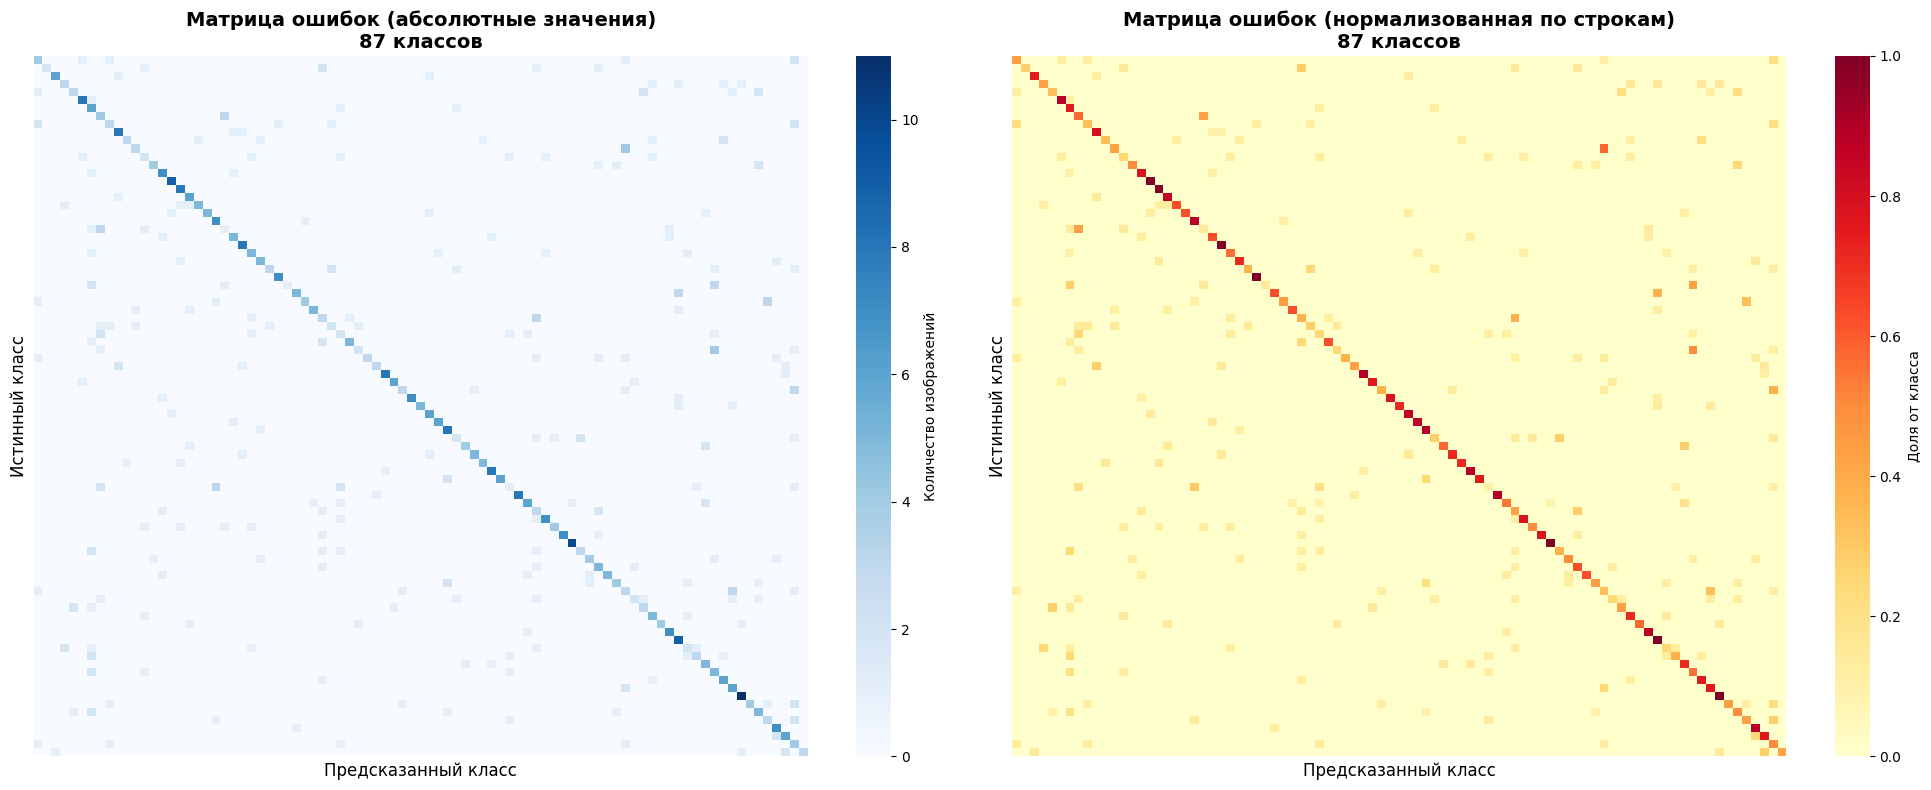


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 424 (60.06%)
 Ошибок: 282 (39.94%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Hiddenite                           → Spodumene                           :    4 (50.0%)
 2. Benitoite                           → Sapphire Blue                       :    4 (57.1%)
 3. Sapphire Blue                       → Tanzanite                           :    3 (33.3%)
 4. Peridot                             → Chrome Diopside                     :    3 (30.0%)
 5. Kyanite                             → Zircon                              :    3 (37.5%)
 6. Garnet Red                          → Pyrope                              :    3 (37.5%)
 7. Emerald                             → Tsavorite                           :    3 (33.3%)
 8. Dumortierite                        → Sodalite                            :    3 (37.5%)
 9. Diaspore                            → Spodumene             

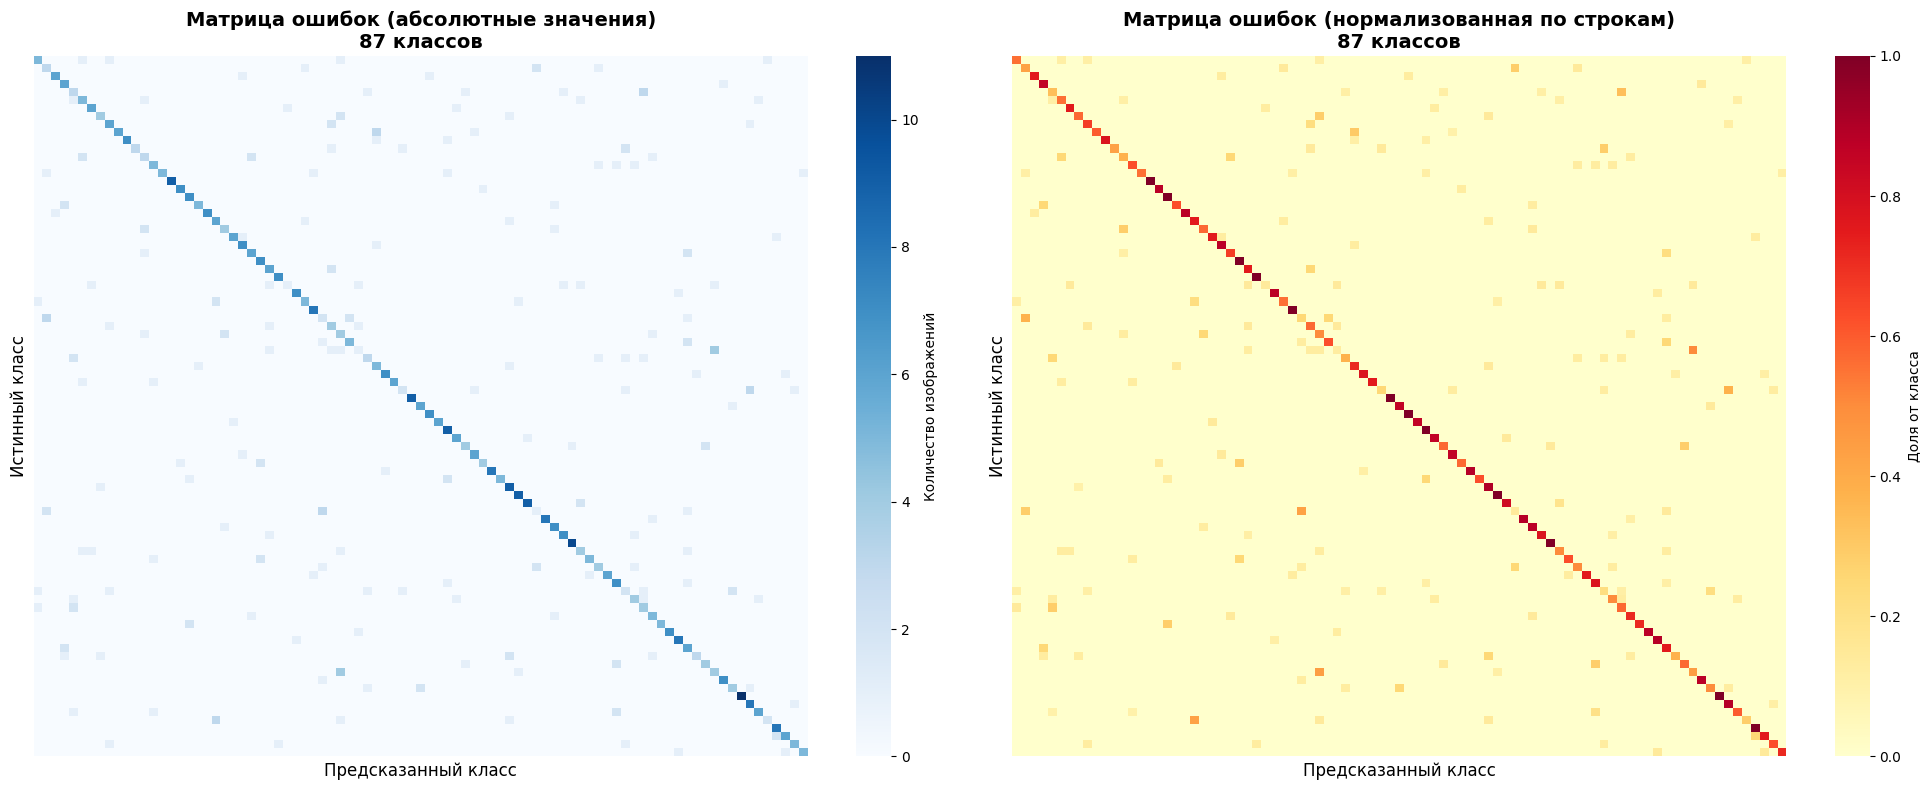


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 487 (68.98%)
 Ошибок: 219 (31.02%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Spodumene                           → Grossular                           :    4 (44.4%)
 2. Hiddenite                           → Spodumene                           :    4 (50.0%)
 3. Tsavorite                           → Chrome Diopside                     :    3 (42.9%)
 4. Pyrope                              → Garnet Red                          :    3 (42.9%)
 5. Kyanite                             → Topaz                               :    3 (37.5%)
 6. Garnet Red                          → Almandine                           :    3 (37.5%)
 7. Aventurine Green                    → Jade                                :    3 (30.0%)
 8. Amethyst                            → Sapphire Purple                     :    3 (33.3%)
 9. Variscite                           → Turquoise             

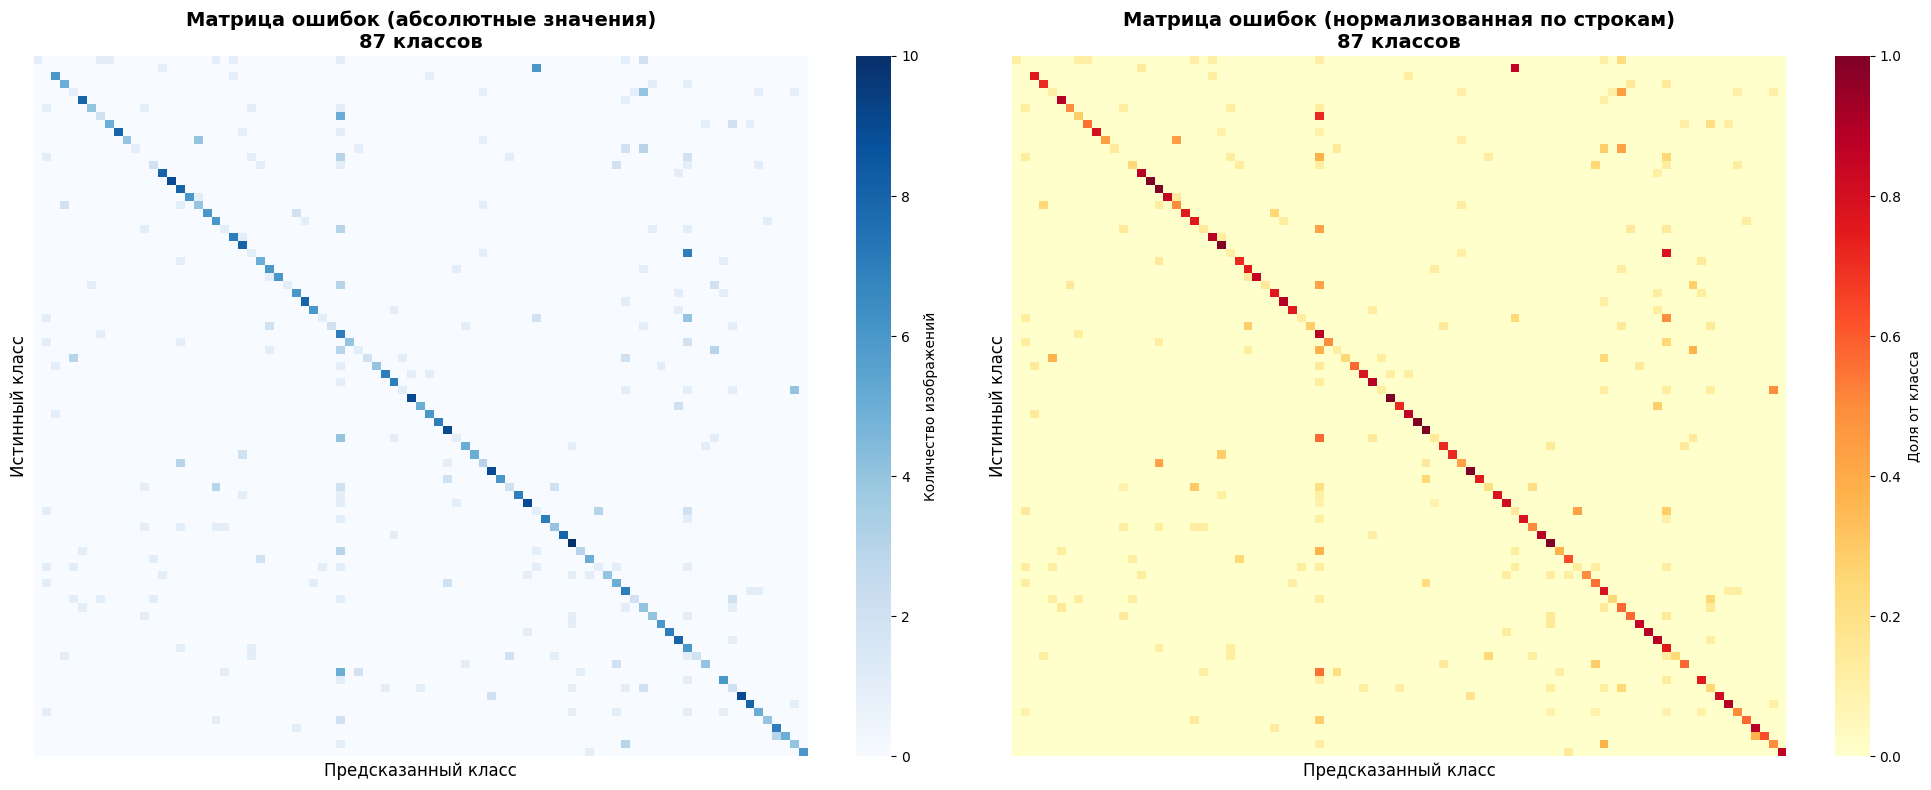


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 422 (59.77%)
 Ошибок: 284 (40.23%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Citrine                             → Spessartite                         :    7 (77.8%)
 2. Almandine                           → Pyrope                              :    6 (85.7%)
 3. Spodumene                           → Grossular                           :    5 (55.6%)
 4. Andradite                           → Grossular                           :    5 (71.4%)
 5. Morganite                           → Grossular                           :    4 (57.1%)
 6. Kyanite                             → Zircon                              :    4 (50.0%)
 7. Garnet Red                          → Spessartite                         :    4 (50.0%)
 8. Aventurine Yellow                   → Chalcedony                          :    4 (44.4%)
 9. Amethyst                            → Sapphire Purple       

/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

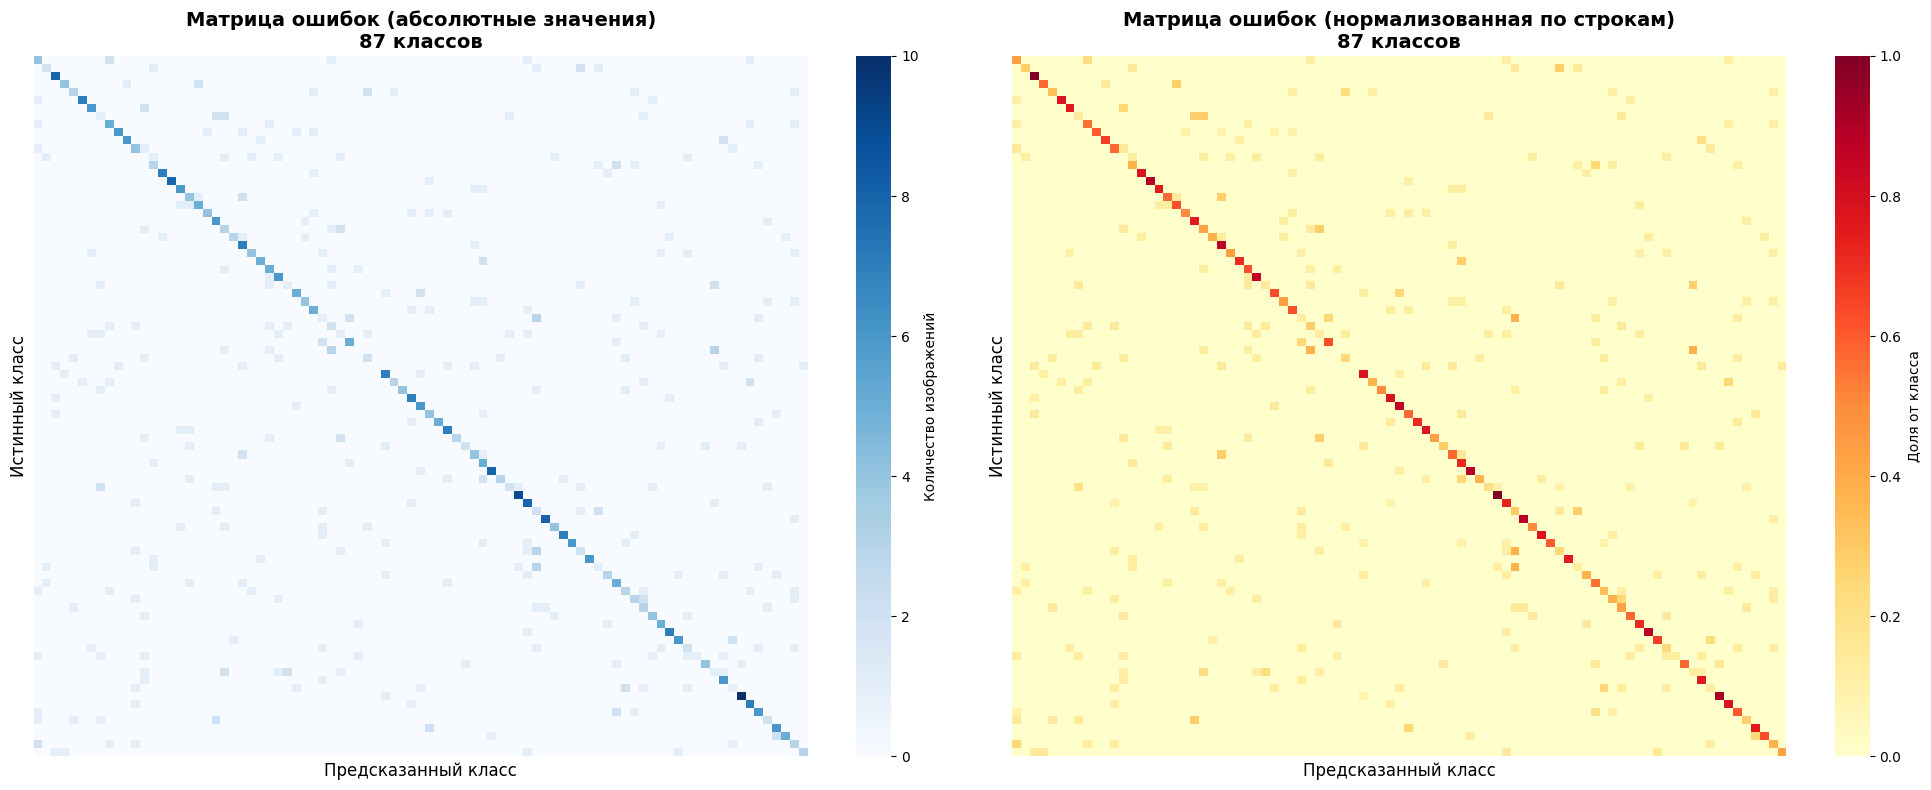


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 377 (53.40%)
 Ошибок: 329 (46.60%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Rhodolite                           → Pyrope                              :    3 (37.5%)
 2. Quartz Smoky                        → Pyrope                              :    3 (37.5%)
 3. Hiddenite                           → Spodumene                           :    3 (37.5%)
 4. Hiddenite                           → Goshenite                           :    3 (37.5%)
 5. Garnet Red                          → Pyrope                              :    3 (37.5%)
 6. Zircon                              → Alexandrite                         :    2 (25.0%)
 7. Variscite                           → Turquoise                           :    2 (25.0%)
 8. Turquoise                           → Larimar                             :    2 (25.0%)
 9. Tsavorite                           → Chrome Diopside       

/tmp/ipykernel_98532/2700547350.py:177: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/oogis/Документы/practice/CV_lab3/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129351 (\N{FIRST PLACE MEDAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


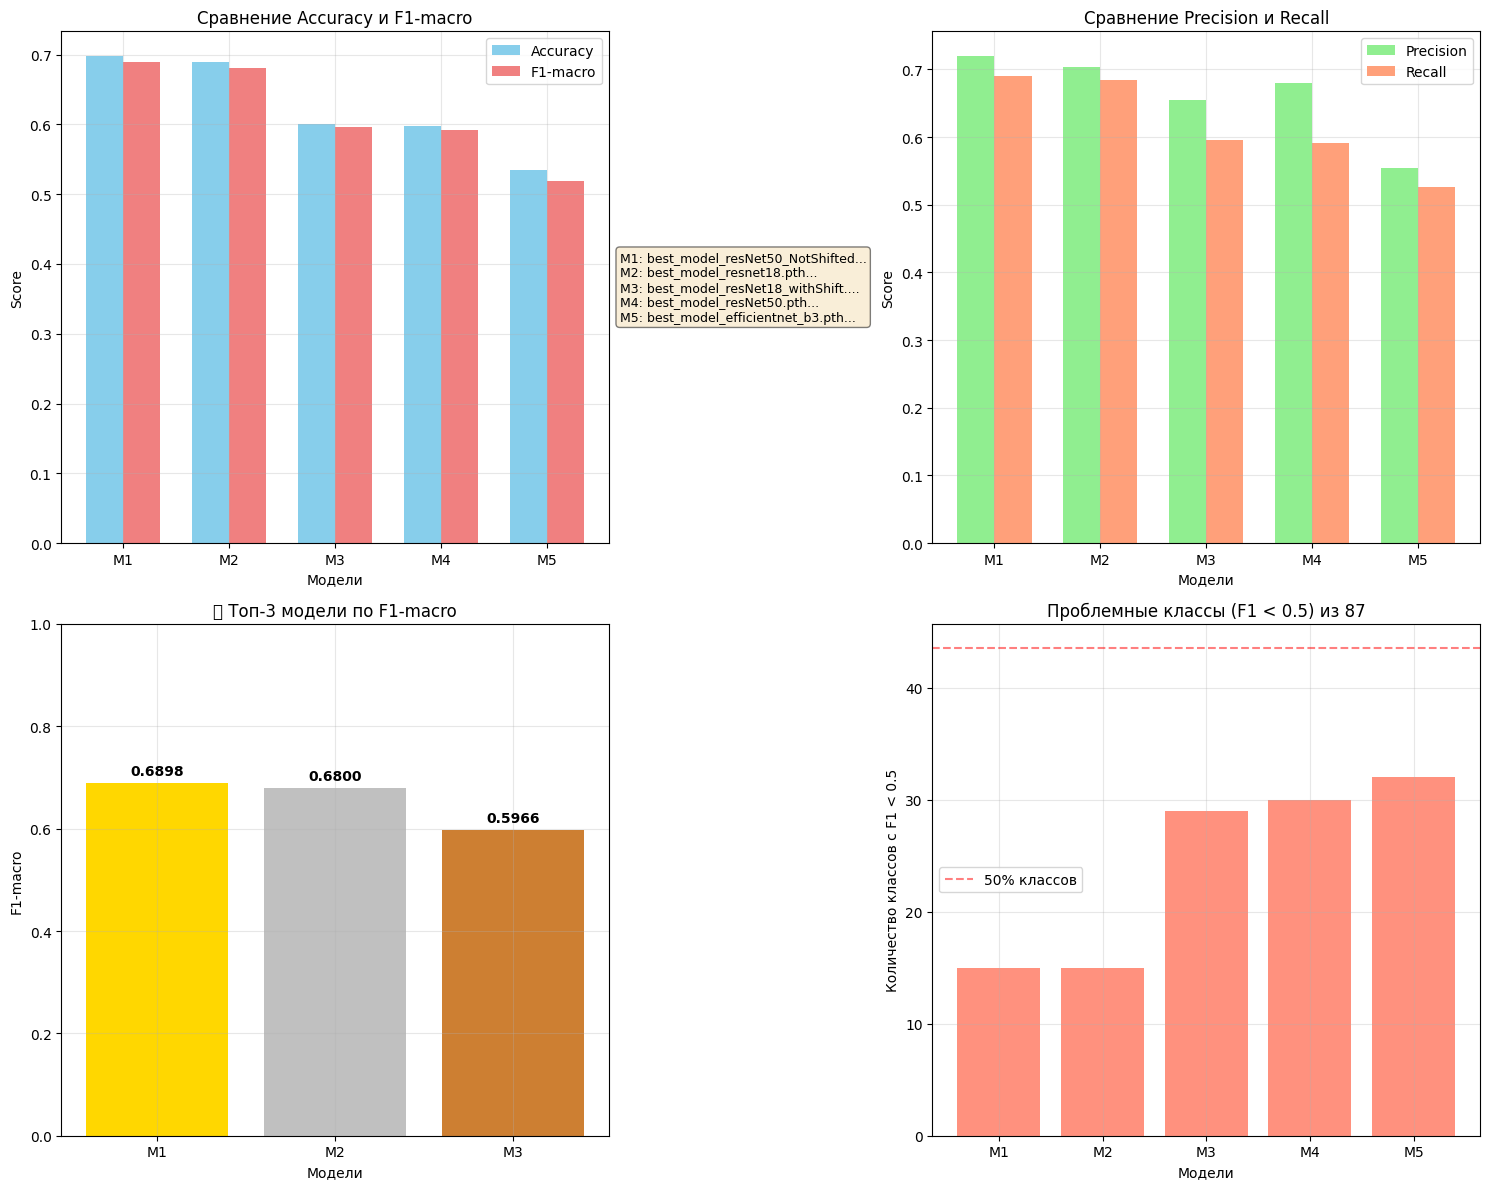


🔍 Соответствие номеров моделей:
   M1: best_model_resNet50_NotShifted.pth
   M2: best_model_resnet18.pth
   M3: best_model_resNet18_withShift.pth
   M4: best_model_resNet50.pth
   M5: best_model_efficientnet_b3.pth

📁 Результаты сохранены в 'model_comparison_results.csv'


,Модель,Accuracy,F1 (macro),F1 (weighted),Точность (macro),Полнота (macro),Размер теста,Лучшие классы (F1),Худшие классы (F1),Классов с F1<0.5
0,best_model_resNet50_NotShifted.pth,0.6983,0.6898,0.6978,0.7204,0.6898,706,"Blue Lace Agate (1.00), Labradorite (1.00), Quartz Rutilated (1.00)","Garnet Red (0.12), Pyrope (0.13), Hiddenite (0.15)",15/87 (17.2%)
1,best_model_resnet18.pth,0.6898,0.6800,0.6855,0.7039,0.6849,706,"Blue Lace Agate (1.00), Labradorite (1.00), Tigers Eye (1.00)","Hiddenite (0.17), Pyrope (0.17), Diaspore (0.22)",15/87 (17.2%)
2,best_model_resNet18_withShift.pth,0.6006,0.5966,0.6002,0.6546,0.5955,706,"Quartz Rutilated (0.95), Prehnite (0.94), Diamond (0.93)","Peridot (0.12), Chrysoberyl (0.15), Grossular (0.22)",29/87 (33.3%)
3,best_model_resNet50.pth,0.5977,0.5916,0.5972,0.6801,0.5908,706,"Blue Lace Agate (1.00), Malachite (1.00), Labradorite (0.95)","Almandine (0.00), Beryl Golden (0.00), Spodumene (0.00)",30/87 (34.5%)
4,best_model_efficientnet_b3.pth,0.5340,0.5194,0.5278,0.5545,0.5265,706,"Blue Lace Agate (0.94), Prehnite (0.90), Opal (0.89)","Beryl Golden (0.00), Hiddenite (0.00), Jade (0.00)",32/87 (36.8%)


In [26]:
import pandas as pd
from tabulate import tabulate

def evaluate_all_models(models_dict, dataloaders, class_names, device):
    """
    Оценивает все загруженные модели и возвращает сводную таблицу
    """
    results_summary = []
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*60}")
        print(f"📊 Оценка модели: {model_name}")
        print(f"{'='*60}")
        
        # Получаем предсказания
        preds, labels, probs, metrics = evaluate_model_with_f1(
            model, dataloaders['test'], class_names, dataloaders['test'].dataset.__len__()
        )
        
        # Собираем основные метрики
        summary = {
            'Модель': model_name,
            'Accuracy': metrics['accuracy'],
            'F1 (macro)': metrics['f1_macro'],
            'F1 (weighted)': metrics['f1_weighted'],
            'Точность (macro)': metrics['report']['macro avg']['precision'],
            'Полнота (macro)': metrics['report']['macro avg']['recall'],
            'Размер теста': len(labels)
        }
        
        # ИСПРАВЛЕНО: Добавляем информацию о лучших классах
        report_df = pd.DataFrame(metrics['report']).T
        # Берем только строки с классами (исключаем macro avg, weighted avg)
        classes_df = report_df[report_df.index.isin(class_names)]
        
        # Лучшие 3 класса по F1
        best_classes = classes_df.nlargest(3, 'f1-score')[['f1-score']]
        best_classes_list = []
        for idx, row in best_classes.iterrows():
            best_classes_list.append(f"{idx} ({row['f1-score']:.2f})")
        summary['Лучшие классы (F1)'] = ', '.join(best_classes_list)
        
        # ИСПРАВЛЕНО: Худшие 3 класса по F1
        worst_classes = classes_df.nsmallest(3, 'f1-score')[['f1-score']]
        worst_classes_list = []
        for idx, row in worst_classes.iterrows():
            worst_classes_list.append(f"{idx} ({row['f1-score']:.2f})")
        summary['Худшие классы (F1)'] = ', '.join(worst_classes_list)
        
        # Считаем количество классов с F1 < 0.5
        low_f1_classes = sum(1 for f1 in metrics['f1_per_class'] if f1 < 0.5)
        summary['Классов с F1<0.5'] = f"{low_f1_classes}/{len(class_names)} ({low_f1_classes/len(class_names)*100:.1f}%)"
        
        results_summary.append(summary)
        
        # Рисуем матрицу ошибок
        cm, cm_norm = plot_confusion_matrix(labels, preds, class_names)
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame(results_summary)
    
    # Сортируем по F1-macro (лучшие сверху)
    results_df = results_df.sort_values('F1 (macro)', ascending=False).reset_index(drop=True)
    
    return results_df

# Функция для красивой печати таблицы
def print_summary_table(results_df):
    """
    Печатает красивую сводную таблицу
    """
    print("\n" + "="*100)
    print("📊 ИТОГОВАЯ ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ")
    print("="*100)
    
    # Форматируем числовые значения для печати
    display_df = results_df.copy()
    for col in ['Accuracy', 'F1 (macro)', 'F1 (weighted)', 'Точность (macro)', 'Полнота (macro)']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
    
    # Выбираем только основные колонки для компактности
    cols_to_display = ['Модель', 'Accuracy', 'F1 (macro)', 'F1 (weighted)', 'Классов с F1<0.5']
    display_df = display_df[cols_to_display]
    
    # Печатаем таблицу
    print(tabulate(display_df, headers='keys', tablefmt='grid', showindex=False))
    
    print("\n" + "="*100)
    print("🏆 ЛУЧШАЯ МОДЕЛЬ ПО F1-MACRO:")
    best_model = results_df.iloc[0]
    print(f"   {best_model['Модель']} (F1-macro: {best_model['F1 (macro)']:.4f}, Accuracy: {best_model['Accuracy']:.4f})")
    
    print("\n📈 СРАВНЕНИЕ МЕТРИК:")
    for i, row in results_df.iterrows():
        medal = "🥇" if i == 0 else "🥈" if i == 1 else "🥉" if i == 2 else "  "
        print(f"{medal} {i+1}. {row['Модель']:<40} F1: {row['F1 (macro)']:.4f} | Acc: {row['Accuracy']:.4f}")
    
    return best_model

# Функция для визуализации сравнения
def plot_models_comparison(results_df):
    """
    Строит графики сравнения моделей
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Сравнение Accuracy и F1-macro
    ax = axes[0, 0]
    x = range(len(results_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], results_df['Accuracy'], width, label='Accuracy', color='skyblue')
    ax.bar([i + width/2 for i in x], results_df['F1 (macro)'], width, label='F1-macro', color='lightcoral')
    
    ax.set_xlabel('Модели')
    ax.set_ylabel('Score')
    ax.set_title('Сравнение Accuracy и F1-macro')
    ax.set_xticks(x)
    ax.set_xticklabels([f"M{i+1}" for i in x], rotation=0)  # Используем короткие метки
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Добавляем легенду с названиями моделей
    legend_text = "\n".join([f"M{i+1}: {name[:30]}..." for i, name in enumerate(results_df['Модель'])])
    ax.text(1.02, 0.5, legend_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Сравнение Precision и Recall
    ax = axes[0, 1]
    ax.bar([i - width/2 for i in x], results_df['Точность (macro)'], width, label='Precision', color='lightgreen')
    ax.bar([i + width/2 for i in x], results_df['Полнота (macro)'], width, label='Recall', color='lightsalmon')
    
    ax.set_xlabel('Модели')
    ax.set_ylabel('Score')
    ax.set_title('Сравнение Precision и Recall')
    ax.set_xticks(x)
    ax.set_xticklabels([f"M{i+1}" for i in x], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Топ-3 модели по F1
    ax = axes[1, 0]
    top3 = results_df.head(3)
    colors = ['gold', 'silver', '#cd7f32']  # золото, серебро, бронза
    
    bars = ax.bar(range(len(top3)), top3['F1 (macro)'], color=colors)
    ax.set_xlabel('Модели')
    ax.set_ylabel('F1-macro')
    ax.set_title('🥇 Топ-3 модели по F1-macro')
    ax.set_xticks(range(len(top3)))
    ax.set_xticklabels([f"M{results_df.index.get_loc(i)+1}" for i in top3.index], rotation=0)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    # Добавляем значения на столбцы
    for bar, val in zip(bars, top3['F1 (macro)']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Количество классов с низким F1
    ax = axes[1, 1]
    # Извлекаем число из строки вида "X/87 (X.X%)"
    low_f1_counts = [int(row['Классов с F1<0.5'].split('/')[0]) for _, row in results_df.iterrows()]
    total_classes = len(class_names)
    
    bars = ax.bar(x, low_f1_counts, color='tomato', alpha=0.7)
    ax.axhline(y=total_classes/2, color='red', linestyle='--', alpha=0.5, label='50% классов')
    ax.set_xlabel('Модели')
    ax.set_ylabel('Количество классов с F1 < 0.5')
    ax.set_title(f'Проблемные классы (F1 < 0.5) из {total_classes}')
    ax.set_xticks(x)
    ax.set_xticklabels([f"M{i+1}" for i in x], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Печатаем соответствие номеров моделей
    print("\n🔍 Соответствие номеров моделей:")
    for i, name in enumerate(results_df['Модель']):
        print(f"   M{i+1}: {name}")

# ============================================
# ЗАПУСК ОЦЕНКИ ВСЕХ МОДЕЛЕЙ
# ============================================

# Загружаем словарь моделей (как у вас в коде)
models_dict = {}

# Проходим по всем файлам в директории
for filename in os.listdir():
    if filename.endswith(".pth"):
        print(f"\n📥 Загрузка модели: {filename}")
        
        # Создаем новую модель с той же архитектурой
        if "18" in filename:
            model = models.resnet18(weights=None)
        elif "efficientnet_b3" in filename:
            model = models.efficientnet_b3(weights=None)
        else:
            model = models.resnet50(weights=None)
            
        if "efficientnet_b3" in filename:
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
        else:
            model.fc = nn.Linear(model.fc.in_features, len(class_names))
            
        # Загружаем сохраненные веса
        try:
            if filename == "best_model_resnet18.pth":
                state_dict = torch.load(filename, map_location=device)
                model.load_state_dict(state_dict)
            else:
                checkpoint = torch.load(filename, map_location=device)
                if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
                else:
                    model.load_state_dict(checkpoint)
            
            model = model.to(device)
            model.eval()
            models_dict[filename] = model
            print(f"  ✅ Модель загружена")
        except Exception as e:
            print(f"  ❌ Ошибка загрузки {filename}: {e}")

# ОЦЕНИВАЕМ ВСЕ МОДЕЛИ
if models_dict:
    results_df = evaluate_all_models(models_dict, dataloaders, class_names, device)
    
    # ПЕЧАТАЕМ СВОДНУЮ ТАБЛИЦУ
    best_model = print_summary_table(results_df)
    
    # СТРОИМ ГРАФИКИ СРАВНЕНИЯ
    plot_models_comparison(results_df)
    
    # СОХРАНЯЕМ РЕЗУЛЬТАТЫ В CSV
    results_df.to_csv('model_comparison_results.csv', index=False)
    print("\n📁 Результаты сохранены в 'model_comparison_results.csv'")
    
    # ПОКАЗЫВАЕМ ТАБЛИЦУ В КРАСИВОМ ФОРМАТЕ
    from IPython.display import display, HTML
    
    def display_pretty_table(df):
        """
        Отображает красивую таблицу в Jupyter
        """
        # Стилизуем DataFrame
        styled_df = df.style.background_gradient(subset=['Accuracy', 'F1 (macro)', 'F1 (weighted)'], cmap='YlOrRd')
        styled_df = styled_df.format({
            'Accuracy': '{:.4f}',
            'F1 (macro)': '{:.4f}',
            'F1 (weighted)': '{:.4f}',
            'Точность (macro)': '{:.4f}',
            'Полнота (macro)': '{:.4f}'
        })
        
        # Подсвечиваем лучшие значения
        styled_df = styled_df.highlight_max(subset=['Accuracy', 'F1 (macro)', 'F1 (weighted)'], color='lightgreen')
        
        display(styled_df)
    
    # Отображаем таблицу
    display_pretty_table(results_df)
else:
    print("❌ Нет загруженных моделей для оценки")